In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [20]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [21]:
class DNN_9(nn.Module):
    def __init__(self, input_dim):
        super(DNN_9, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)


        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x = torch.relu(self.layer2(x))

        x = torch.relu(self.layer3(x))

        x = torch.relu(self.layer4(x))

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [22]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [ ]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = DNN_9(
        input_dim=X_train_tensor.shape[1]
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float() 
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [24]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 17:43:29,948] A new study created in memory with name: no-name-9cf86514-54e8-443c-871a-4fc55a9b01d2
/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:44:04,849] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.06280933709089934, 'weight_decay': 0.0009157725484706331}. Best is trial 0 with value: 0.0.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:44:46,762] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.03078273673297758, 'weight_decay': 0.0021774319633341395}. Best is trial 0 with value: 0.0.


Early stopping at epoch 15
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:46:23,731] Trial 2 finished with value: 0.2915599959510088 and parameters: {'learning_rate': 0.007909783366759503, 'weight_decay': 0.014152911813421596}. Best is trial 2 with value: 0.2915599959510088.


Early stopping at epoch 36
Final MCC: 0.2916


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:46:55,616] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.05497277732180984, 'weight_decay': 0.00022398155822892489}. Best is trial 2 with value: 0.2915599959510088.


Early stopping at epoch 11
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:48:04,381] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.026551622357341816, 'weight_decay': 0.08265992231936556}. Best is trial 2 with value: 0.2915599959510088.


Early stopping at epoch 25
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:48:06,996] Trial 5 pruned. 
[I 2024-12-04 17:48:09,622] Trial 6 pruned. 
[I 2024-12-04 17:48:41,049] Trial 7 pruned. 
[I 2024-12-04 17:50:24,891] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.0006368304707194801, 'weight_decay': 0.01662643824590539}. Best is trial 2 with value: 0.2915599959510088.


Early stopping at epoch 38
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:51:46,051] Trial 9 finished with value: 0.34662704822186946 and parameters: {'learning_rate': 0.017767224706669128, 'weight_decay': 0.008774614078178068}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 30
Final MCC: 0.3466


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:51:48,638] Trial 10 pruned. 
[I 2024-12-04 17:52:22,633] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.00790579523484746, 'weight_decay': 0.010339116626981497}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:52:25,339] Trial 12 pruned. 
[I 2024-12-04 17:52:28,057] Trial 13 pruned. 
[I 2024-12-04 17:53:02,517] Trial 14 finished with value: 0.0 and parameters: {'learning_rate': 0.01741807035573369, 'weight_decay': 0.02914542428312479}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:53:05,138] Trial 15 pruned. 
[I 2024-12-04 17:53:07,694] Trial 16 pruned. 
[I 2024-12-04 17:53:10,511] Trial 17 pruned. 
[I 2024-12-04 17:56:41,039] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 0.0001049131018389227, 'weight_decay': 0.07866748689013159}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 78
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:56:43,583] Trial 19 pruned. 
[I 2024-12-04 17:56:46,252] Trial 20 pruned. 
[I 2024-12-04 17:56:48,879] Trial 21 pruned. 
[I 2024-12-04 17:56:51,580] Trial 22 pruned. 
[I 2024-12-04 17:56:53,886] Trial 23 pruned. 
[I 2024-12-04 17:56:56,588] Trial 24 pruned. 
[I 2024-12-04 17:56:59,085] Trial 25 pruned. 
[I 2024-12-04 17:57:57,646] Trial 26 finished wi

Early stopping at epoch 21
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:58:00,334] Trial 27 pruned. 
[I 2024-12-04 17:58:03,120] Trial 28 pruned. 
[I 2024-12-04 17:58:05,818] Trial 29 pruned. 
[I 2024-12-04 17:58:08,528] Trial 30 pruned. 
[I 2024-12-04 17:58:53,946] Trial 31 finished with value: 0.0 and parameters: {'learning_rate': 0.06177133390925258, 'weight_decay': 0.0010366734651435718}. Best is trial 9 with value: 0

Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:58:56,601] Trial 32 pruned. 
[I 2024-12-04 17:58:58,619] Trial 33 pruned. 
[I 2024-12-04 17:59:01,372] Trial 34 pruned. 
[I 2024-12-04 17:59:04,394] Trial 35 pruned. 
[I 2024-12-04 17:59:06,996] Trial 36 pruned. 
[I 2024-12-04 17:59:09,629] Trial 37 pruned. 
[I 2024-12-04 17:59:12,311] Trial 38 pruned. 
[I 2024-12-04 17:59:15,011] Trial 39 pruned. 
[I

Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:00:05,688] Trial 44 pruned. 
[I 2024-12-04 18:00:08,502] Trial 45 pruned. 
[I 2024-12-04 18:00:10,877] Trial 46 pruned. 
[I 2024-12-04 18:00:13,353] Trial 47 pruned. 
[I 2024-12-04 18:00:16,071] Trial 48 pruned. 
[I 2024-12-04 18:00:18,872] Trial 49 pruned. 
[I 2024-12-04 18:00:21,705] Trial 50 pruned. 
[I 2024-12-04 18:01:02,472] Trial 51 finished wi

Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:01:39,606] Trial 52 finished with value: 0.0 and parameters: {'learning_rate': 0.038464143462018124, 'weight_decay': 0.05556255135123138}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:01:42,069] Trial 53 pruned. 
[I 2024-12-04 18:01:44,744] Trial 54 pruned. 
[I 2024-12-04 18:02:38,000] Trial 55 finished with value: 0.0 and parameters: {'learning_rate': 0.09751508580304566, 'weight_decay': 0.030273291935047082}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 19
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:02:40,848] Trial 56 pruned. 
[I 2024-12-04 18:02:43,626] Trial 57 pruned. 
[I 2024-12-04 18:02:46,304] Trial 58 pruned. 
[I 2024-12-04 18:02:49,027] Trial 59 pruned. 
[I 2024-12-04 18:02:51,793] Trial 60 pruned. 
[I 2024-12-04 18:02:54,841] Trial 61 pruned. 
[I 2024-12-04 18:04:15,140] Trial 62 finished with value: 0.0 and parameters: {'learning_rate'

Early stopping at epoch 29
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:04:18,135] Trial 63 pruned. 
[I 2024-12-04 18:04:20,932] Trial 64 pruned. 
[I 2024-12-04 18:04:23,623] Trial 65 pruned. 
[I 2024-12-04 18:06:57,929] Trial 66 finished with value: 0.0 and parameters: {'learning_rate': 0.00014859444104227943, 'weight_decay': 0.09918571237739973}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 53
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:07:00,953] Trial 67 pruned. 
[I 2024-12-04 18:07:03,703] Trial 68 pruned. 
[I 2024-12-04 18:07:53,448] Trial 69 finished with value: 0.0 and parameters: {'learning_rate': 0.07833901750708416, 'weight_decay': 0.011538645502305274}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 17
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:07:55,401] Trial 70 pruned. 
[I 2024-12-04 18:07:58,264] Trial 71 pruned. 
[I 2024-12-04 18:07:59,999] Trial 72 pruned. 
[I 2024-12-04 18:08:01,609] Trial 73 pruned. 
[I 2024-12-04 18:08:03,233] Trial 74 pruned. 
[I 2024-12-04 18:08:05,878] Trial 75 pruned. 
[I 2024-12-04 18:08:08,390] Trial 76 pruned. 
[I 2024-12-04 18:08:11,402] Trial 77 pruned. 
[I

Early stopping at epoch 37
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:10:00,980] Trial 80 pruned. 
[I 2024-12-04 18:11:07,362] Trial 81 finished with value: 0.0 and parameters: {'learning_rate': 0.027940223429511284, 'weight_decay': 0.04547752345019486}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:11:10,418] Trial 82 pruned. 
[I 2024-12-04 18:11:13,175] Trial 83 pruned. 
[I 2024-12-04 18:11:15,896] Trial 84 pruned. 
[I 2024-12-04 18:11:18,585] Trial 85 pruned. 
[I 2024-12-04 18:11:21,421] Trial 86 pruned. 
[I 2024-12-04 18:11:24,448] Trial 87 pruned. 
[I 2024-12-04 18:11:27,376] Trial 88 pruned. 
[I 2024-12-04 18:11:29,816] Trial 89 pruned. 
[I

Early stopping at epoch 58
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:16:13,974] Trial 92 finished with value: 0.0 and parameters: {'learning_rate': 0.00020590285553696302, 'weight_decay': 0.08104097501583021}. Best is trial 9 with value: 0.34662704822186946.


Early stopping at epoch 41
Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:16:16,662] Trial 93 pruned. 
[I 2024-12-04 18:16:19,118] Trial 94 pruned. 
[I 2024-12-04 18:21:02,359] Trial 95 finished with value: 0.0 and parameters: {'learning_rate': 0.00010051722367597122, 'weight_decay': 0.0347877724722393}. Best is trial 9 with value: 0.34662704822186946.


Final MCC: 0.0000


/tmp/ipykernel_282605/2762187026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_282605/2762187026.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 18:21:05,536] Trial 96 pruned. 
[I 2024-12-04 18:21:08,623] Trial 97 pruned. 
[I 2024-12-04 18:21:11,235] Trial 98 pruned. 
[I 2024-12-04 18:21:13,375] Trial 99 pruned. 


Best Parameters:  {'learning_rate': 0.017767224706669128, 'weight_decay': 0.008774614078178068}
Best Validation F1:  0.34662704822186946


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.6542
Epoch [1/100], Train Loss: 0.6542, Val Loss: 0.6533
Epoch [2/100], Loss: 0.6676
Epoch [2/100], Train Loss: 0.6676, Val Loss: 0.6564
Epoch [3/100], Loss: 0.6685
Epoch [3/100], Train Loss: 0.6685, Val Loss: 0.6644
Epoch [4/100], Loss: 0.6693
Epoch [4/100], Train Loss: 0.6693, Val Loss: 0.6564
Epoch [5/100], Loss: 0.6688
Epoch [5/100], Train Loss: 0.6688, Val Loss: 0.6534
Epoch [6/100], Loss: 0.6696
Epoch [6/100], Train Loss: 0.6696, Val Loss: 0.6556
Epoch [7/100], Loss: 0.6689
Epoch [7/100], Train Loss: 0.6689, Val Loss: 0.6545
Epoch [8/100], Loss: 0.6686
Epoch [8/100], Train Loss: 0.6686, Val Loss: 0.6580
Epoch [9/100], Loss: 0.6689
Epoch [9/100], Train Loss: 0.6689, Val Loss: 0.6540
Epoch [10/100], Loss: 0.6679
Epoch [10/100], Train Loss: 0.6679, Val Loss: 0.6597
Epoch [11/100], Loss: 0.6684
Epoch [11/100], Train Loss: 0.6684, Val Loss: 0.6525
Epoch [12/100], Loss: 0.6685
Epoch [12/100], Train Loss: 0.6685, Val Loss: 0.6536
Epoch [13/100], Loss: 0.6685
Epoch

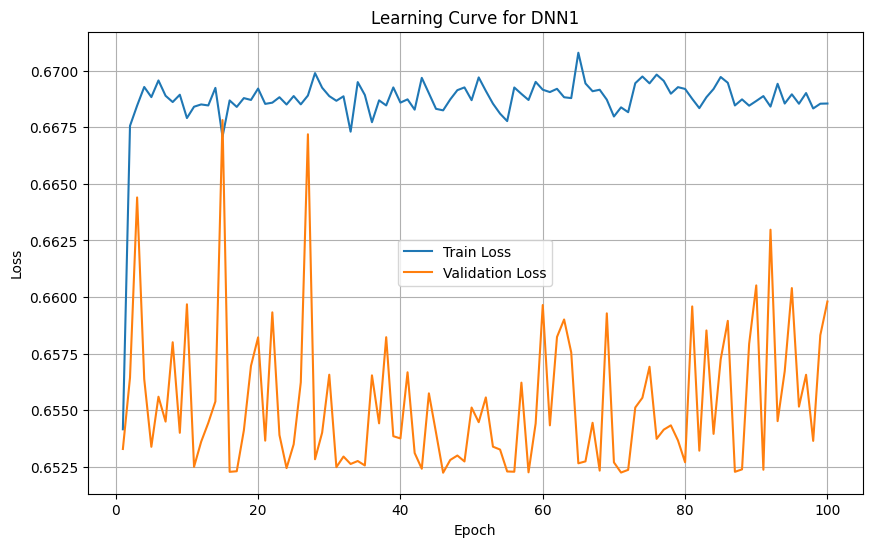

In [25]:
best_params=study.best_params
model = DNN_9(input_dim=X_train_tensor.shape[1],).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.39%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


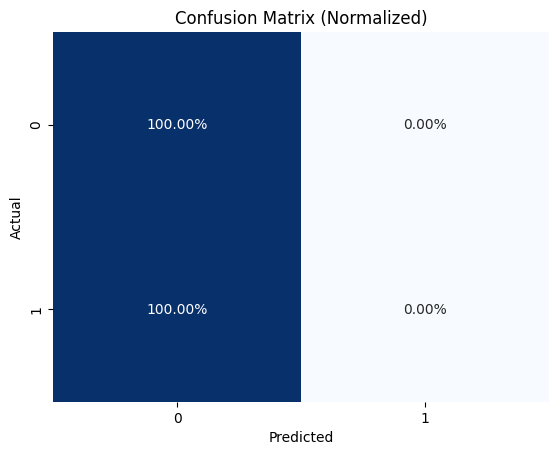

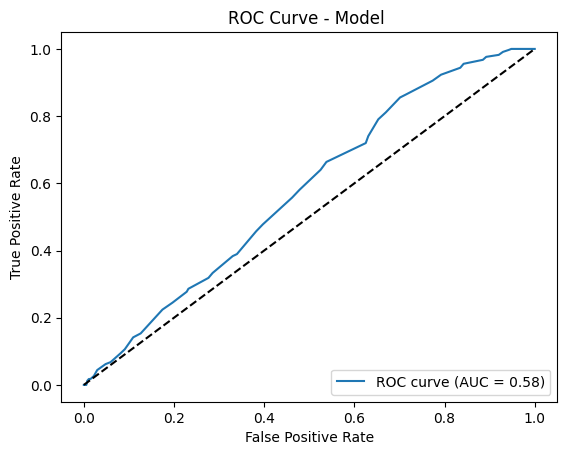

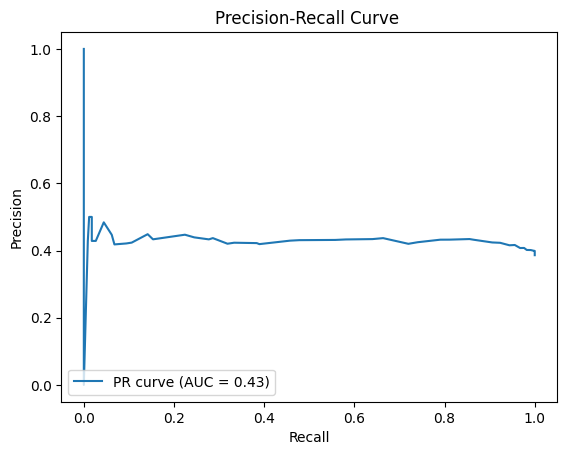

In [26]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [27]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_9.pth')
